# BEE 4750 Lab 2: Uncertainty and Monte Carlo

**Name**: Priya Shah

**ID**: 5244508

> **Due Date**
>
> Wednesday, 9/25/24, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Downloads/BEE4750/labs/lab2-ps742-1`
   Installed libfdk_aac_jll ────────── v2.0.3+0
   Installed GR_jll ────────────────── v0.73.7+0
   Installed libdecor_jll ──────────── v0.2.2+0
   Installed Unitful ───────────────── v1.21.0
   Installed Opus_jll ──────────────── v1.3.3+0
   Installed StatsFuns ─────────────── v1.3.2
   Installed HypergeometricFunctions ─ v0.3.24
   Installed Pango_jll ─────────────── v1.54.1+0
   Installed PDMats ────────────────── v0.11.31
   Installed HarfBuzz_jll ──────────── v8.3.1+0
   Installed SimpleBufferStream ────── v1.2.0
   Installed fzf_jll ───────────────── v0.53.0+0
   Installed PtrArrays ─────────────── v1.2.1
   Installed SpecialFunctions ──────── v2.4.0
   Installed TranscodingStreams ────── v0.11.2
   Installed Dbus_jll ──────────────── v1.14.10+0
   Installed Rmath_jll ─────────────── v0.5.1+0
   Installed GLFW_jll ──────────────── v3.4.0+1
   Installed JLFzf ─────────────────── v0.1.8
   Installed CodecZlib ─────────

In [2]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting

## Overview

In this lab, we will use Monte Carlo analysis to analyze a version of
the culmination of every episode of the long-running game show [The
Price Is Right](https://en.wikipedia.org/wiki/The_Price_Is_Right): the
[Showcase](https://en.wikipedia.org/wiki/The_Price_Is_Right#Showcase).

Monte Carlo methods involve the simulation of random numbers from
probability distributions. In an environmental context, we often
propagate these random numbers through some more complicated model and
then compute a resulting statistic which is relevant for assessing
performance or risk, such as an average outcome or a particular
quantile.

You should always start any computing with random numbers by setting a
“seed,” which controls the sequence of numbers which are generated
(since these are not *really* random, just “pseudorandom”). In Julia, we
do this with the `Random.seed!()` function.

In [5]:
Random.seed!(1)

TaskLocalRNG()

It doesn’t matter what seed you set, though different seeds might result
in slightly different values. But setting a seed means every time your
notebook is run, the answer will be the same.

> **Seeds and Reproducing Solutions**
>
> If you don’t re-run your code in the same order or if you re-run the
> same cell repeatedly, you will not get the same solution. If you’re
> working on a specific problem, you might want to re-use
> `Random.seed()` near any block of code you want to re-evaluate
> repeatedly.

### Probability Distributions and Julia

Julia provides a common interface for probability distributions with the
[`Distributions.jl`
package](https://juliastats.org/Distributions.jl/stable/). The basic
workflow for sampling from a distribution is:

1.  Set up the distribution. The specific syntax depends on the
    distribution and what parameters are required, but the general call
    is the similar. For a normal distribution or a uniform distribution,
    the syntax is

    ``` julia
    # you don't have to name this "normal_distribution"
    # μ is the mean and σ is the standard deviation
    normal_distribution = Normal(μ, σ)
    # a is the upper bound and b is the lower bound; these can be set to +Inf or -Inf for an unbounded distribution in one or both directions.
    uniform_distribution = Uniform(a, b)
    ```

    There are lots of both
    [univariate](https://juliastats.org/Distributions.jl/stable/univariate/#Index)
    and
    [multivariate](https://juliastats.org/Distributions.jl/stable/multivariate/)
    distributions, as well as the ability to create your own, but we
    won’t do anything too exotic here.

2.  Draw samples. This uses the `rand()` command (which, when used
    without a distribution, just samples uniformly from the interval
    $[0, 1]$.) For example, to sample from our normal distribution
    above:

    ``` julia
    # draw n samples
    rand(normal_distribution, n)
    ```

Putting this together, let’s say that we wanted to simulate 100
six-sided dice rolls. We could use a [Discrete Uniform
distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.DiscreteUniform).

In [6]:
dice_dist = DiscreteUniform(1, 6) # can generate any integer between 1 and 6
dice_rolls = rand(dice_dist, 100) # simulate rolls

100-element Vector{Int64}:
 1
 3
 5
 4
 6
 2
 5
 5
 5
 2
 ⋮
 3
 6
 5
 5
 6
 3
 6
 6
 6

And then we can plot a histogram of these rolls:

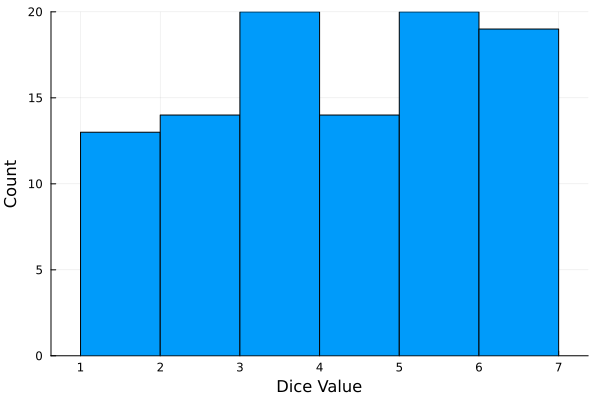

In [7]:
histogram(dice_rolls, legend=:false, bins=6)
ylabel!("Count")
xlabel!("Dice Value")

### Instructions

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

## Exercise (3 Points)

The Showcase is the final round of every episode of The Price is Right,
matching the two big winners from the episode. Each contestant is shown
a “showcase” of prizes, which are usually some combination of a trip, a
motor vehicle, some furniture, and maybe some other stuff. They then
each have to make a bid on the retail price of the showcase. The rules
are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within \$250 of the retail price and is closer
    than their opponent, they win both showcases.

Your goal is to find a wager which maximizes your expected winnings,
which we may as well call utility, based on your assessment of the
probability of your showcase retail price. Make the following
assumptions about your expected winnings if you don’t overbid:

-   If you win both showcases, the value is the double of the single
    showcase value.
-   If you did not win both showcases but bid under the showcase value,
    the probability of being outbid increases linearly as the distance
    between your bid and the value increases (in other words, if you bid
    the exact value, you win with probability 1, and if you bid \$0, you
    win with probability 0).

We’ll assume that the distribution of all showcases offered by the show
is given as truncated normal distribution, which means a normal
distribution which has an upper and/or lower bound. `Distributions.jl`
makes it easy to specify truncations on any distribution, not just
normal distributions. For example, we’ll use the distribution shown in
<a href="#fig-values" class="quarto-xref">Figure 1</a> for the showcase
values (you can just directly use the `showcase_dist` distribution in
your lab code).

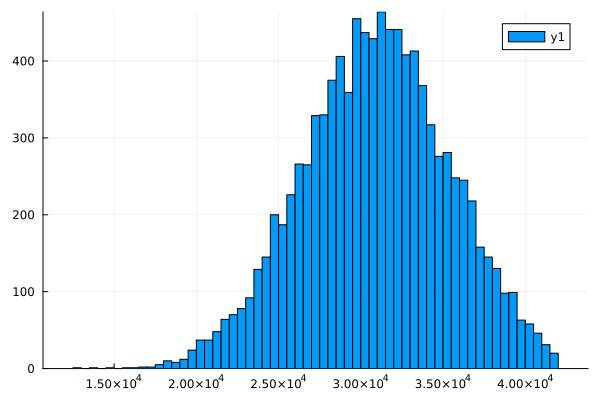

In [9]:
showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
showcase_samples = rand(showcase_dist, 10_000)
histogram(showcase_samples)

Find your expected winnings if you bid \$35,000. Plot the outcomes of
your Monte Carlo experiment (iterations vs. running estimate). How did
you decide how many samples to use?

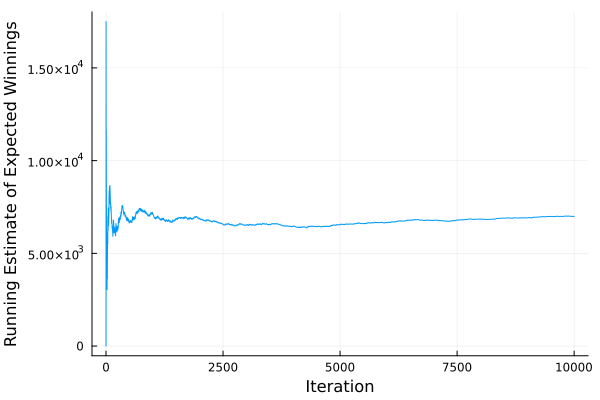

In [23]:
# function to simulate showcase wins 
function monte_carlo(bid, n_samples)
    winnings = []
    for i = 1:n_samples
        showcase_value = rand(showcase_dist)
        # overbid
        if bid > showcase_value
            push!(winnings, 0)
        # within $250
        elseif showcase_value - bid <= 250
            push!(winnings, 2 * showcase_value)
        # underbid
        else
            probability_of_winning = 1 - ((showcase_value - bid) / showcase_value)
            push!(winnings, showcase_value * probability_of_winning)
        end
    end
    return winnings
end

bid = 35000
n_samples = 10000
winnings = monte_carlo(bid, n_samples)

# plot the running estimate of the expected winnings vs iteration
running_estimate = cumsum(winnings) ./ (1:n_samples)
plot(1:n_samples, running_estimate, legend=:false, xlabel="Iteration", ylabel="Running Estimate of Expected Winnings")


In [24]:
# expected value of the winnings
expected_winnings = mean(winnings)
display(expected_winnings)

6982.998730515029

## Explanation of the Code

This code uses a Monte Carlo simulation to estimate the expected winnings for a contestant who bids $35,000 on The Price is Right's Showcase. The function monte_carlo simulates this process multiple times, generating a distribution of possible outcomes for the contestant’s winnings based on their bid.

For the case of an overbid, the contestant wins nothing, which I modeled by appending a value of 0 to the winnings array:
``` 
push!(winnings, 0)

 ```
 For the case whre the bid is within $250, the contestant wins both showcases which results in a payout equal to twice the showcase value which I showed as: 
``` 
push!(winnings, 2 * showcase_value)

 ```
Lastly, for the case of an underbid, if the bid is below the showcase value but more than $250 off, the contestant’s probability of winning decreases as the bid becomes further from the actual value. This is represented by a linear relationship: the probability of winning is reduced proportionally to the difference between the bid and the showcase value. The contestant's winnings in this case are weighted by this probability:
``` 
probability_of_winning = 1 - ((showcase_value - bid) / showcase_value)
push!(winnings, showcase_value * probability_of_winning)
 ```

In order to plot the running estimate of the expected winnings vs the iteration, I wrote the line `running_estimate = cumsum(winnings) ./ (1:n_samples)`, which calculates the cumulative sum of winnings after each iteration and divides it by the number of iterations so far, giving a running average of the expected winnings. By plotting this running estimate, I could see whether it converges, which indicates if enough samples have been used. 

I chose the number of samples to be 10,000 because initially, the running estimate fluctuates, but over time, it stabilizes. By plotting the running estimate over 10,000 iterations, I could confirm that the estimate was converging.  Through the running estimate plot, I was able to determine whether this number of iterations was sufficient as the estimate converged, indicating that 10,000 samples was appropriate. 

In order to calculate the expected value of the winnings, I took the mean of the winnings vector. For this simmulation, I found that with a bid of $35,000 and 10,000 samples, the expected winnings is estimated to be around $7000. 

## References

Put any consulted sources here, including classmates you worked with/who
helped you.
- Classmated consulted: Bailey Belinger, Camila Monter 
- Learned to use the "cumsum" function here: https://www.jlhub.com/julia/manual/en/function/cumsum#:~:text=It%20is%20worth%20mentioning%20the,performance%20and%20control%20over%20precision.